**Astart VS DIJKSTRA**

Procesando grafo con 100 nodos
Procesando grafo con 300 nodos
Procesando grafo con 600 nodos
Procesando grafo con 1000 nodos

RESULTADOS:
   Nodos Algoritmo  Tiempo (s)  Memoria (MB)
0    100  Dijkstra    0.002649      0.021530
1    100        A*    0.000441      0.005325
2    300  Dijkstra    0.022094      0.056778
3    300        A*    0.003525      0.019714
4    600  Dijkstra    0.014139      0.057877
5    600        A*    0.000925      0.011703
6   1000  Dijkstra    0.066712      0.136520
7   1000        A*    0.002154      0.024841


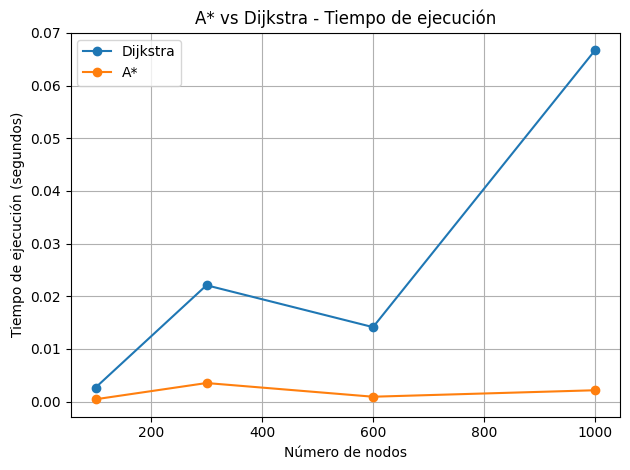

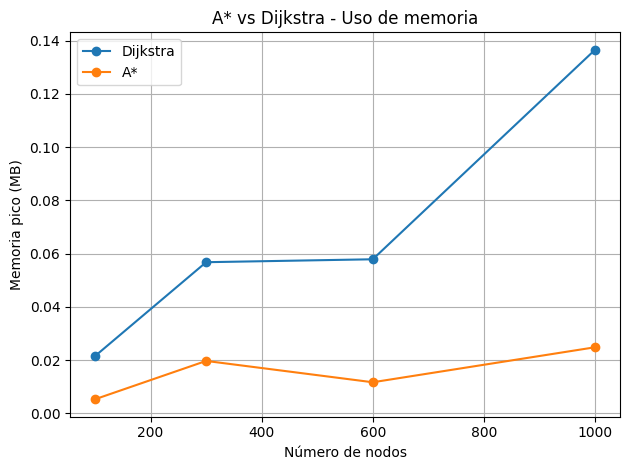

In [8]:
import networkx as nx
import random
import time
import tracemalloc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Configuración
# -------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# -------------------------------
# Medición de tiempo y memoria
# -------------------------------
def medir(algoritmo, *args, **kwargs):
    tracemalloc.start()
    inicio = time.perf_counter()
    algoritmo(*args, **kwargs)
    fin = time.perf_counter()
    _, pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return fin - inicio, pico / 1024**2  # segundos, MB

# -------------------------------
# Generar grafo geométrico
# -------------------------------
def generar_grafo(n):
    """
    Genera un grafo geométrico aleatorio con pesos euclidianos.
    Ideal para comparar A* vs Dijkstra.
    """
    G = nx.random_geometric_graph(n, radius=0.25, seed=SEED)

    for u, v in G.edges():
        pu = G.nodes[u]['pos']
        pv = G.nodes[v]['pos']
        G[u][v]['weight'] = ((pu[0] - pv[0])**2 + (pu[1] - pv[1])**2) ** 0.5

    return G

# -------------------------------
# Heurística euclidiana (A*)
# -------------------------------
def heuristica(G, a, b):
    x1, y1 = G.nodes[a]['pos']
    x2, y2 = G.nodes[b]['pos']
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

# -------------------------------
# Experimento principal
# -------------------------------
tamaños = [100, 300, 600, 1000]
resultados = []

for n in tamaños:
    print(f"Procesando grafo con {n} nodos")

    G = generar_grafo(n)
    nodos = list(G.nodes())

    origen = nodos[0]
    destino = nodos[-1]

    # Dijkstra
    t_d, m_d = medir(
        nx.dijkstra_path,
        G, origen, destino,
        weight='weight'
    )

    # A*
    t_a, m_a = medir(
        nx.astar_path,
        G, origen, destino,
        heuristic=lambda a, b: heuristica(G, a, b),
        weight='weight'
    )

    resultados.append({
        "Nodos": n,
        "Algoritmo": "Dijkstra",
        "Tiempo (s)": t_d,
        "Memoria (MB)": m_d
    })

    resultados.append({
        "Nodos": n,
        "Algoritmo": "A*",
        "Tiempo (s)": t_a,
        "Memoria (MB)": m_a
    })

# -------------------------------
# Resultados en tabla
# -------------------------------
df = pd.DataFrame(resultados)
print("\nRESULTADOS:")
print(df)

# -------------------------------
# Gráfico de tiempo
# -------------------------------
plt.figure()
for alg in ["Dijkstra", "A*"]:
    sub = df[df["Algoritmo"] == alg]
    plt.plot(sub["Nodos"], sub["Tiempo (s)"], marker='o', label=alg)

plt.xlabel("Número de nodos")
plt.ylabel("Tiempo de ejecución (segundos)")
plt.title("A* vs Dijkstra - Tiempo de ejecución")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# Gráfico de memoria
# -------------------------------
plt.figure()
for alg in ["Dijkstra", "A*"]:
    sub = df[df["Algoritmo"] == alg]
    plt.plot(sub["Nodos"], sub["Memoria (MB)"], marker='o', label=alg)

plt.xlabel("Número de nodos")
plt.ylabel("Memoria pico (MB)")
plt.title("A* vs Dijkstra - Uso de memoria")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



**BELLMAN - FORD VS DIJKSTRA**

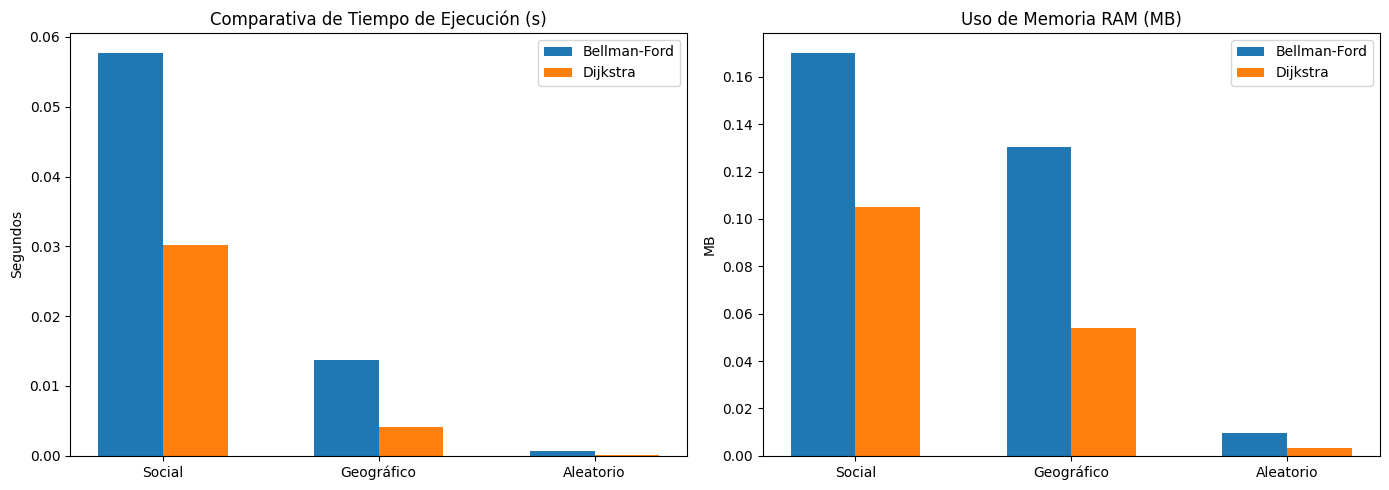

Resumen de datos promedio:
      Dataset     Algoritmo  Tiempo (s)  Memoria (MB)
0   Aleatorio  Bellman-Ford    0.057699      0.170099
1   Aleatorio      Dijkstra    0.030235      0.104925
2  Geográfico  Bellman-Ford    0.013740      0.130521
3  Geográfico      Dijkstra    0.004154      0.054022
4      Social  Bellman-Ford    0.000674      0.009656
5      Social      Dijkstra    0.000180      0.003224


In [9]:
import networkx as nx
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tracemalloc import start, stop, get_traced_memory, start as start_trace, stop as stop_trace

# 1. Configuración de Algoritmos
def run_benchmark(G, source, target):
    results = {}

    # --- Dijkstra (HeapQ) --- [cite: 113, 169]
    start_trace()
    start_time = time.perf_counter()
    nx.dijkstra_path_length(G, source, target, weight='weight')
    end_time = time.perf_counter()
    _, peak_mem = get_traced_memory()
    stop_trace()

    results['Dijkstra'] = {
        'time': end_time - start_time,
        'memory': peak_mem / 10**6  # Convertido a MB [cite: 199]
    }

    # --- Bellman-Ford --- [cite: 118, 171]
    start_trace()
    start_time = time.perf_counter()
    nx.bellman_ford_path_length(G, source, target, weight='weight')
    end_time = time.perf_counter()
    _, peak_mem = get_traced_memory()
    stop_trace()

    results['Bellman-Ford'] = {
        'time': end_time - start_time,
        'memory': peak_mem / 10**6
    }

    return results

# 2. Generación de Datasets (Semillas fijas para reproducibilidad [cite: 206])
np.random.seed(42)
datasets = {
    "Social": nx.karate_club_graph(), #
    "Geográfico": nx.grid_2d_graph(20, 20), # [cite: 182]
    "Aleatorio": nx.erdos_renyi_graph(500, 0.1, seed=42) #
}

# Añadir pesos a las aristas (Dijkstra requiere pesos no negativos [cite: 114])
for name, G in datasets.items():
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = np.random.uniform(1.0, 10.0)

# 3. Ejecución de Pruebas (10 ejecuciones por cada una [cite: 206])
all_results = []
for name, G in datasets.items():
    nodes = list(G.nodes())
    u, v = nodes[0], nodes[-1]

    for _ in range(10):
        res = run_benchmark(G, u, v)
        for alg, metrics in res.items():
            all_results.append({
                "Dataset": name,
                "Algoritmo": alg,
                "Tiempo (s)": metrics['time'],
                "Memoria (MB)": metrics['memory']
            })

df = pd.DataFrame(all_results)
summary = df.groupby(['Dataset', 'Algoritmo']).mean().reset_index()

# 4. Visualización de Resultados [cite: 204]
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica de Tiempo
for i, alg in enumerate(summary['Algoritmo'].unique()):
    data = summary[summary['Algoritmo'] == alg]
    ax[0].bar(np.arange(len(datasets)) + i*0.3, data['Tiempo (s)'], width=0.3, label=alg)

ax[0].set_xticks(np.arange(len(datasets)) + 0.15)
ax[0].set_xticklabels(datasets.keys())
ax[0].set_title("Comparativa de Tiempo de Ejecución (s)")
ax[0].set_ylabel("Segundos")
ax[0].legend()

# Gráfica de Memoria
for i, alg in enumerate(summary['Algoritmo'].unique()):
    data = summary[summary['Algoritmo'] == alg]
    ax[1].bar(np.arange(len(datasets)) + i*0.3, data['Memoria (MB)'], width=0.3, label=alg)

ax[1].set_xticks(np.arange(len(datasets)) + 0.15)
ax[1].set_xticklabels(datasets.keys())
ax[1].set_title("Uso de Memoria RAM (MB)")
ax[1].set_ylabel("MB")
ax[1].legend()

plt.tight_layout()
plt.show()

print("Resumen de datos promedio:")
print(summary)

**BFS VS DIJKSTRA**

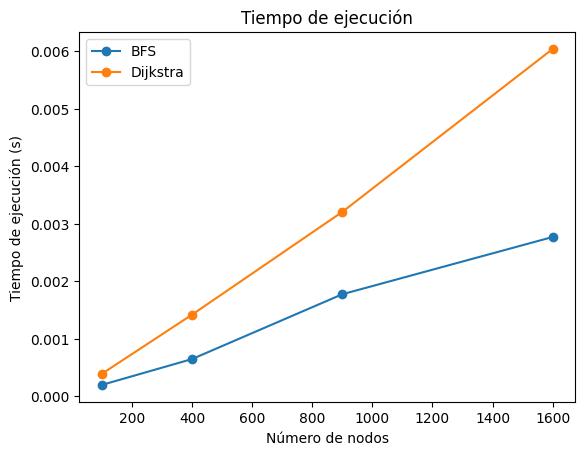

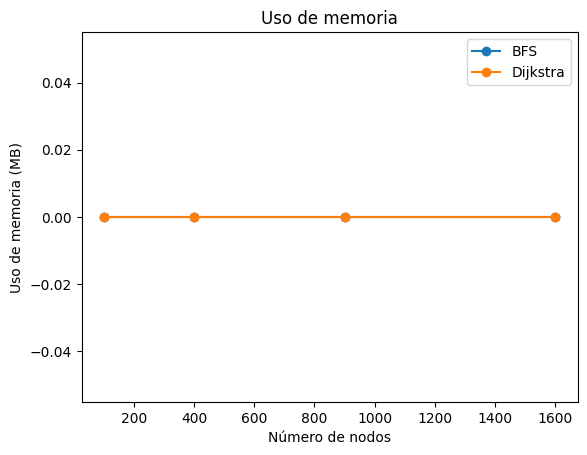

In [10]:
!pip install memory-profiler

import networkx as nx
import time
import random
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

# -----------------------------
# Funciones de medición
# -----------------------------

def medir_bfs(G, source, target):
    def ejecutar():
        nx.shortest_path(G, source=source, target=target)
    mem = memory_usage(ejecutar, max_iterations=1)
    inicio = time.perf_counter()
    ejecutar()
    fin = time.perf_counter()
    return fin - inicio, max(mem) - min(mem)

def medir_dijkstra(G, source, target):
    def ejecutar():
        nx.dijkstra_path(G, source=source, target=target)
    mem = memory_usage(ejecutar, max_iterations=1)
    inicio = time.perf_counter()
    ejecutar()
    fin = time.perf_counter()
    return fin - inicio, max(mem) - min(mem)

# -----------------------------
# Tamaños de grafo
# -----------------------------

tamaños = [10, 20, 30, 40]  # grids NxN
nodos = []
tiempos_bfs = []
tiempos_dijkstra = []
mem_bfs = []
mem_dijkstra = []

# -----------------------------
# Experimentos
# -----------------------------

for n in tamaños:
    G_bfs = nx.grid_2d_graph(n, n)
    G_dijkstra = nx.grid_2d_graph(n, n)

    for u, v in G_dijkstra.edges():
        G_dijkstra[u][v]['weight'] = random.randint(1, 10)

    source = (0, 0)
    target = (n-1, n-1)

    t_bfs, m_bfs = medir_bfs(G_bfs, source, target)
    t_dij, m_dij = medir_dijkstra(G_dijkstra, source, target)

    nodos.append(n * n)
    tiempos_bfs.append(t_bfs)
    tiempos_dijkstra.append(t_dij)
    mem_bfs.append(m_bfs)
    mem_dijkstra.append(m_dij)

# -----------------------------
# Gráficas
# -----------------------------

# Tiempo de ejecución
plt.figure()
plt.plot(nodos, tiempos_bfs, marker='o', label='BFS')
plt.plot(nodos, tiempos_dijkstra, marker='o', label='Dijkstra')
plt.xlabel("Número de nodos")
plt.ylabel("Tiempo de ejecución (s)")
plt.title("Tiempo de ejecución")
plt.legend()
plt.show()

# Uso de memoria
plt.figure()
plt.plot(nodos, mem_bfs, marker='o', label='BFS')
plt.plot(nodos, mem_dijkstra, marker='o', label='Dijkstra')
plt.xlabel("Número de nodos")
plt.ylabel("Uso de memoria (MB)")
plt.title("Uso de memoria")
plt.legend()
plt.show()

**Astart VS BFS VS BELLMAN - FORD VS DIJKSTRA**

Procesando: Social: Karate Club | Nodos: 34 | Aristas: 78
Procesando: Social: Florentine Families | Nodos: 15 | Aristas: 20
Procesando: Social: Davis Women | Nodos: 32 | Aristas: 205
Procesando: Mapa: Grid 20x20 | Nodos: 400 | Aristas: 760
Procesando: Mapa: Geo Threshold | Nodos: 200 | Aristas: 7233
Procesando: Sintético: Erdős-Rényi | Nodos: 500 | Aristas: 12575
Procesando: Sintético: Barabási-Albert | Nodos: 300 | Aristas: 596
Procesando: Sintético: Watts-Strogatz | Nodos: 200 | Aristas: 400

=== RESULTADOS EXPERIMENTALES ===
                        Dataset     Algoritmo  Tiempo Promedio (s)  \
0           Social: Karate Club      Dijkstra             0.000184   
1           Social: Karate Club  Bellman-Ford             0.000768   
2           Social: Karate Club           BFS             0.000034   
3   Social: Florentine Families      Dijkstra             0.000127   
4   Social: Florentine Families  Bellman-Ford             0.000312   
5   Social: Florentine Families           BFS 

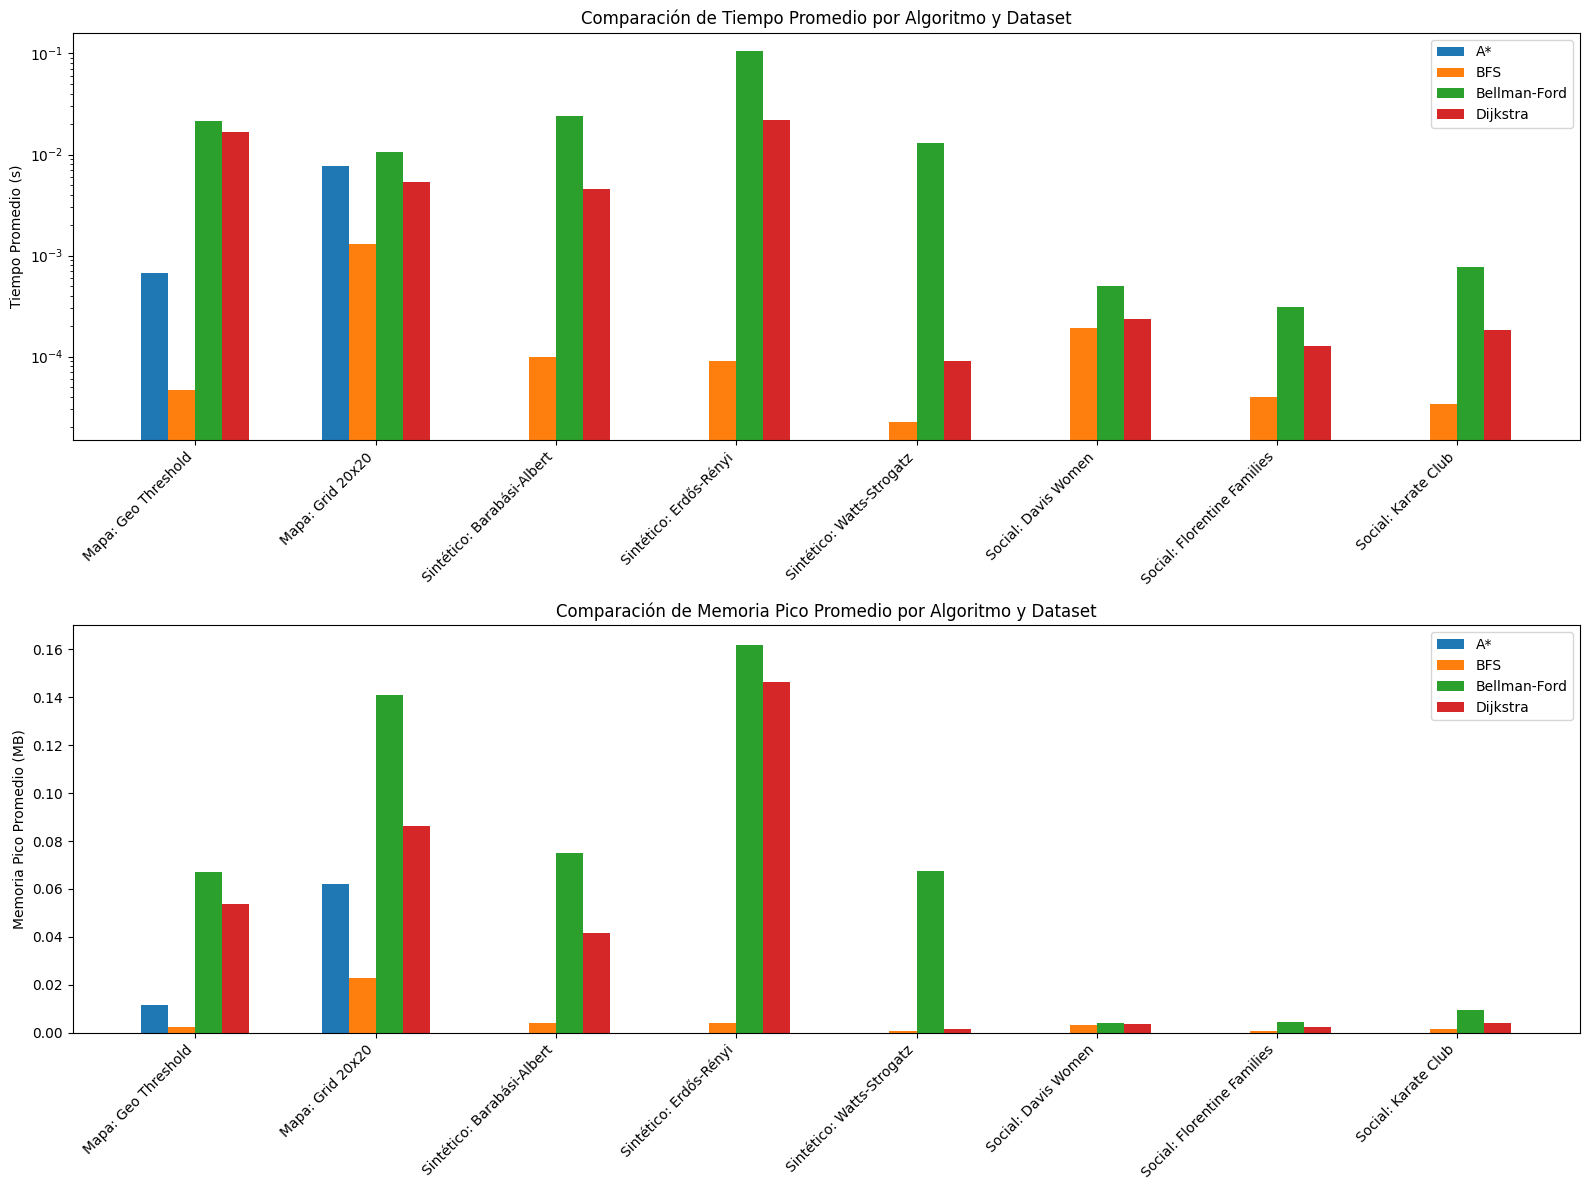

In [11]:
import networkx as nx
import time
import tracemalloc
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Configuración de semilla para reproducibilidad
# ---------------------------------------------------------
SEMILLA = 42
random.seed(SEMILLA)
np.random.seed(SEMILLA)

# ---------------------------------------------------------
# Generación de conjuntos de grafos (datasets)
# ---------------------------------------------------------
def obtener_datasets_grafos():
    grafos = []

    # 1. Grafos de redes sociales
    grafo_davis = nx.davis_southern_women_graph()
    grafo_davis_proyectado = nx.bipartite.projected_graph(grafo_davis, grafo_davis.nodes())

    grafos.append(("Social: Karate Club", nx.karate_club_graph()))
    grafos.append(("Social: Florentine Families", nx.florentine_families_graph()))
    grafos.append(("Social: Davis Women", grafo_davis_proyectado))

    # 2. Mapas sintéticos con coordenadas
    grafo_grid = nx.grid_2d_graph(20, 20)
    for u, v in grafo_grid.edges():
        grafo_grid[u][v]['weight'] = 1.0
        grafo_grid.nodes[u]['pos'] = u
        grafo_grid.nodes[v]['pos'] = v
    grafos.append(("Mapa: Grid 20x20", grafo_grid))

    grafo_geo = nx.geographical_threshold_graph(200, 10, seed=SEMILLA)
    for u, v in grafo_geo.edges():
        pos_u = grafo_geo.nodes[u]['pos']
        pos_v = grafo_geo.nodes[v]['pos']
        distancia = ((pos_u[0] - pos_v[0])**2 + (pos_u[1] - pos_v[1])**2)**0.5
        grafo_geo[u][v]['weight'] = distancia
    grafos.append(("Mapa: Geo Threshold", grafo_geo))

    # 3. Grafos sintéticos aleatorios
    grafo_er = nx.erdos_renyi_graph(500, 0.1, seed=SEMILLA)
    for u, v in grafo_er.edges():
        grafo_er[u][v]['weight'] = random.random()
    grafos.append(("Sintético: Erdős-Rényi", grafo_er))

    grafo_ba = nx.barabasi_albert_graph(300, 2, seed=SEMILLA)
    for u, v in grafo_ba.edges():
        grafo_ba[u][v]['weight'] = random.random()
    grafos.append(("Sintético: Barabási-Albert", grafo_ba))

    grafo_ws = nx.watts_strogatz_graph(200, 4, 0.3, seed=SEMILLA)
    for u, v in grafo_ws.edges():
        grafo_ws[u][v]['weight'] = random.random()
    grafos.append(("Sintético: Watts-Strogatz", grafo_ws))

    return grafos

# ---------------------------------------------------------
# Ejecución de experimentos con algoritmos de caminos mínimos
# ---------------------------------------------------------
def ejecutar_experimento(grafos, numero_ejecuciones=10):
    resultados = []

    for nombre, grafo in grafos:
        print(f"Procesando: {nombre} | Nodos: {len(grafo.nodes)} | Aristas: {len(grafo.edges)}")

        nodo_origen = list(grafo.nodes())[0]
        nodo_destino = list(grafo.nodes())[-1]

        algoritmos = [
            ("Dijkstra", nx.dijkstra_path),
            ("Bellman-Ford", nx.bellman_ford_path),
            ("BFS", nx.shortest_path)
        ]

        tiene_posicion = nx.get_node_attributes(grafo, 'pos')
        if tiene_posicion:
            algoritmos.append(("A*", nx.astar_path))

        for nombre_algoritmo, funcion_algoritmo in algoritmos:
            tiempos = []
            memorias = []

            for _ in range(numero_ejecuciones):
                tracemalloc.start()
                tiempo_inicio = time.perf_counter()

                try:
                    if nombre_algoritmo == "BFS":
                        funcion_algoritmo(grafo, nodo_origen, nodo_destino)
                    elif nombre_algoritmo == "A*":
                        def heuristica_euclidiana(a, b):
                            x1, y1 = grafo.nodes[a]['pos']
                            x2, y2 = grafo.nodes[b]['pos']
                            return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

                        funcion_algoritmo(
                            grafo,
                            nodo_origen,
                            nodo_destino,
                            heuristic=heuristica_euclidiana,
                            weight='weight'
                        )
                    else:
                        funcion_algoritmo(
                            grafo,
                            nodo_origen,
                            nodo_destino,
                            weight='weight'
                        )

                except nx.NetworkXNoPath:
                    pass
                except Exception as error:
                    print(f"Error en {nombre_algoritmo}: {error}")

                tiempo_fin = time.perf_counter()
                memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
                tracemalloc.stop()

                tiempos.append(tiempo_fin - tiempo_inicio)
                memorias.append(memoria_pico / 1024**2)

            resultados.append({
                "Dataset": nombre,
                "Algoritmo": nombre_algoritmo,
                "Tiempo Promedio (s)": np.mean(tiempos),
                "Memoria Pico (MB)": np.mean(memorias),
                "Nodos": len(grafo.nodes),
                "Aristas": len(grafo.edges)
            })

    return pd.DataFrame(resultados)

# ---------------------------------------------------------
# Ejecución principal
# ---------------------------------------------------------
datasets = obtener_datasets_grafos()
tabla_resultados = ejecutar_experimento(datasets)

print("\n=== RESULTADOS EXPERIMENTALES ===")
print(tabla_resultados)

# ---------------------------------------------------------
# Visualización separada: Tiempo y Memoria
# ---------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

# Crear pivots para tiempo y memoria
pivot_tiempo = tabla_resultados.pivot(index='Dataset', columns='Algoritmo', values='Tiempo Promedio (s)').fillna(0)
pivot_memoria = tabla_resultados.pivot(index='Dataset', columns='Algoritmo', values='Memoria Pico (MB)').fillna(0)

datasets = pivot_tiempo.index
algoritmos = pivot_tiempo.columns
n_datasets = len(datasets)
anchura = 0.15
indice = np.arange(n_datasets)

# Configurar figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Colores distintos para algoritmos
colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# --- Gráfico de Tiempo ---
for i, algoritmo in enumerate(algoritmos):
    ax1.bar(indice + i*anchura, pivot_tiempo[algoritmo], width=anchura,
            color=colores[i % len(colores)], label=f"{algoritmo}")

ax1.set_xticks(indice + anchura*(len(algoritmos)/2 - 0.5))
ax1.set_xticklabels(datasets, rotation=45, ha='right')
ax1.set_ylabel("Tiempo Promedio (s)")
ax1.set_yscale('log')
ax1.set_title("Comparación de Tiempo Promedio por Algoritmo y Dataset")
ax1.legend()

# --- Gráfico de Memoria ---
for i, algoritmo in enumerate(algoritmos):
    ax2.bar(indice + i*anchura, pivot_memoria[algoritmo], width=anchura,
            color=colores[i % len(colores)], label=f"{algoritmo}")

ax2.set_xticks(indice + anchura*(len(algoritmos)/2 - 0.5))
ax2.set_xticklabels(datasets, rotation=45, ha='right')
ax2.set_ylabel("Memoria Pico Promedio (MB)")
ax2.set_title("Comparación de Memoria Pico Promedio por Algoritmo y Dataset")
ax2.legend()

plt.tight_layout()
plt.show()
